In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import cv2

import matplotlib.pyplot as plt
from mono.mono_head import InferDAM

import torchvision.models as models

xFormers not available
xFormers not available


In [2]:
gt_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/depth'
raft_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/raft'
gms_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/gmstereo'
cres_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/crestero'
cmp_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/research'
left_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/infra1'
right_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/infra2'
mono_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/damv2'
focal = 390.81134033203125
baseline = 94.994
cx = 320.83
cy = 245.31
os.makedirs(cmp_dir, exist_ok=True)
os.makedirs(mono_dir, exist_ok=True)

In [3]:
f_gts = sorted(Path('/home/william/extdisk/data/realsense-D455_depth_image/sample/depth').glob('*.png'))
f_rafts = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/raft").glob('*.npy'))
f_gms = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/gmstereo").glob('*_disp.pfm'))
f_cres = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/crestereo").glob('*.npy'))
f_left = sorted(Path(left_dir).glob('*.png'))
f_right = sorted(Path(right_dir).glob('*.png'))
f_mono = sorted(Path(mono_dir).glob('*.npy'))


In [4]:
import re

def read_pfm(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data*scale


In [5]:
mono = InferDAM()
mono.initialize(model_path='/home/william/extdisk/checkpoints/depth-anything/depth_anything_v2_vits.pth', encoder='vits')

In [6]:
def acc_cmp():
    for gt, raft, gms, cres in zip(f_gts, f_rafts, f_gms, f_cres):
        print(f"currently processing on gt {gt}")
        print(f"currently processing on raft {raft}")
        print(f"currently processing on gms {gms}")
        print(f"currently processing on cres {cres}")

        f_name = gt.name
        
        left_full_name = left_dir+'/'+f_name
        left = cv2.imread(left_full_name, cv2.IMREAD_ANYCOLOR)
        disp = mono.predict(left)
        f_ext = f_name.replace('.png', '.npy')
        np.save(mono_dir+'/'+f_ext, disp)
        

        # gt_ = cv2.imread(gt, cv2.IMREAD_ANYDEPTH).astype(np.float32)
        # d_gt = np.divide(focal*baseline, gt_, where=gt_!=0)
        # d_gt = np.where(gt_ == 0, 0, d_gt)
        # mask_gt = np.where(gt_ == 0)
        # raft_ = -np.load(raft)
        # gms_ = read_pfm(gms)
        # cres_ = np.load(cres)

        # diff_gt_raft = np.zeros_like(d_gt)
        # diff_gt_gms = np.zeros_like(d_gt)
        # diff_gt_cres = np.zeros_like(d_gt)

        # diff_gt_raft[mask_gt] = d_gt[mask_gt] - raft_[mask_gt]
        # diff_gt_gms[mask_gt] = d_gt[mask_gt] - gms_[mask_gt]
        # diff_gt_cres[mask_gt] = d_gt[mask_gt] - cres_[mask_gt]

        # print(f"gt disp max value is {d_gt.max()}, min value is {d_gt.min()}")
        # print(f"raft disp max value is {raft_.max()}, min value is {raft_.min()}")
        # print(f"gt-raft diff max valueis {diff_gt_raft.max()}, min value is {diff_gt_raft.min()}")
        # print(f"gms disp max value is {gms_.max()}, min value is {gms_.min()}")
        # print(f"gt-gms diff max valueis {diff_gt_gms.max()}, min value is {diff_gt_gms.min()}")
        # print(f"cres disp max value is {cres_.max()}, min value is {cres_.min()}")
        # print(f"gt-cres diff max valueis {diff_gt_cres.max()}, min value is {diff_gt_cres.min()}")

        # print("="*77)
        
        # fig, axs = plt.subplots(3, 3, figsize=(10, 8))  # 2 rows, 2 columns

        # # Plot each image on a subplot
        # axs[0, 0].imshow(d_gt, cmap='magma')
        # axs[0, 0].set_title('ground truth')
        # axs[0, 0].axis('off')  # Turn off axis

        # axs[0, 1].imshow(raft_, cmap='magma')
        # axs[0, 1].set_title('RAFT')
        # axs[0, 1].axis('off')

        # axs[0, 2].imshow(diff_gt_raft, cmap='magma')
        # axs[0, 2].set_title('diff')
        # axs[0, 2].axis('off')
        # plt.colorbar(axs[0, 2].imshow(diff_gt_raft, cmap='magma'), ax=axs[0, 2])

        # axs[1, 0].imshow(d_gt, cmap='magma')
        # axs[1, 0].set_title('ground truth')
        # axs[1, 0].axis('off')  # Turn off axis

        # axs[1, 1].imshow(gms_, cmap='magma')
        # axs[1, 1].set_title('GMS')
        # axs[1, 1].axis('off')

        # axs[1, 2].imshow(diff_gt_gms, cmap='magma')
        # axs[1, 2].set_title('diff')
        # axs[1 ,2].axis('off')
        # plt.colorbar(axs[1, 2].imshow(diff_gt_gms, cmap='magma'), ax=axs[1, 2])


        # axs[2, 0].imshow(d_gt, cmap='magma')
        # axs[2, 0].set_title('ground truth')
        # axs[2, 0].axis('off')  # Turn off axis

        # axs[2, 1].imshow(cres_, cmap='magma')
        # axs[2, 1].set_title('CRES')
        # axs[2, 1].axis('off')

        # axs[2, 2].imshow(diff_gt_cres, cmap='magma')
        # axs[2, 2].set_title('diff')
        # axs[2, 2].axis('off')
        # plt.colorbar( axs[2, 2].imshow(diff_gt_cres, cmap='magma'), ax=axs[2, 2])


        # plt.tight_layout()
        # plt.savefig(os.path.join(cmp_dir, gt.name))

In [7]:
from refine.simple_refine_net import SimpleRefineNet
from refine.pose_net import PoseNet

In [8]:
class PoseNet1(nn.Module):
    """
    PoseNet architecture for estimating relative pose between two images.
    
    Attributes:
        encoder (nn.Module): Pretrained CNN encoder (e.g., ResNet18).
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        translation (nn.Linear): Fully connected layer for translation.
        rotation (nn.Linear): Fully connected layer for rotation.
    """
    def __init__(self, encoder='resnet18', pretrained=True):
        super(PoseNet1, self).__init__()
        
        # Load a pretrained ResNet18 model and remove the fully connected layers
        if encoder == 'resnet18':
            self.encoder = models.resnet18(pretrained=pretrained)
            modules = list(self.encoder.children())[:-2]  # Remove avgpool and fc
            self.encoder = nn.Sequential(*modules)
            feature_dim=512
        elif encoder == 'mobilenetv3-small':
            self.encoder = models.mobilenet_v3_small(pretrained=pretrained).features
            feature_dim = 576
        elif encoder == 'mobilenetv3-large':
            self.encoder = models.mobilenet_v3_large(pretrained=pretrained).features
            feature_dim = 960
        else:
            raise NotImplementedError(f"{encoder} has not been supported!, please use one of 'resnet18', 'mobilenetv3-small', 'mobilenetv3-small' instead. ")
        # Freeze encoder weights if needed
        # for param in self.encoder.parameters():
        #     param.requires_grad = False
        
        # Define the pose regression head
        # Assuming encoder outputs features of size 512 x H/32 x W/32 for ResNet18
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(feature_dim * 2, 256)  # Concatenate features from two images
        self.fc2 = nn.Linear(256, 128)
        
        # Output layers for translation and rotation
        self.translation = nn.Linear(128, 3)  # tx, ty, tz
        self.rotation = nn.Linear(128, 3)     # rx, ry, rz (Euler angles)
        
        # Initialize weights for regression layers
        self._init_weights()
        
    def _init_weights(self):
        """
        Initializes the weights of the fully connected layers.
        """
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        
        nn.init.xavier_normal_(self.translation.weight)
        nn.init.constant_(self.translation.bias, 0)
        
        nn.init.xavier_normal_(self.rotation.weight)
        nn.init.constant_(self.rotation.bias, 0)
    
    def forward(self, img1, img2):
        """
        Forward pass to estimate the relative pose between two images.
        
        Args:
            img1 (torch.Tensor): Batch of first images [B, 3, H, W].
            img2 (torch.Tensor): Batch of second images [B, 3, H, W].
        
        Returns:
            translation (torch.Tensor): Estimated translations [B, 3].
            rotation (torch.Tensor): Estimated rotations [B, 3].
        """
        # Encode first image
        feat1 = self.encoder(img1)  # [B, C, H', W']
        feat1 = self.avgpool(feat1)  # [B, C, 1, 1]
        feat1 = feat1.view(feat1.size(0), -1)  # [B, C]
        # Encode second image
        feat2 = self.encoder(img2)  # [B, C, H', W']
        feat2 = self.avgpool(feat2)  # [B, C, 1, 1]
        feat2 = feat2.view(feat2.size(0), -1)  # [B, C]
        
        # Concatenate features
        combined = torch.cat((feat1, feat2), dim=1)  # [B, C*2]
        # Pose regression
        x = F.relu(self.fc1(combined))  # [B, C*2]
        x = F.relu(self.fc2(x))         # [B, C*2]
        
        translation = self.translation(x)  # [B, 3]
        rotation = self.rotation(x)        # [B, 3]
        
        return translation, rotation

In [9]:
ref_net = SimpleRefineNet().to('cuda')
pose_net = PoseNet1().to('cuda')

/home/william/anaconda3/envs/torch2.3.1_cu12.1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/william/anaconda3/envs/torch2.3.1_cu12.1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
I_L = cv2.imread(f_left[0], cv2.IMREAD_ANYCOLOR)
I_L = cv2.cvtColor(I_L, cv2.COLOR_BGR2RGB).astype(np.float32)
I_R = cv2.imread(f_right[0], cv2.IMREAD_ANYCOLOR)
I_R = cv2.cvtColor(I_R, cv2.COLOR_BGR2RGB).astype(np.float32)

d_mono = np.load(f_mono[0], allow_pickle=False)
d_stereo = np.load(f_cres[0])

In [11]:
print(d_mono.shape, d_stereo.shape)

(480, 640) (480, 640)


In [12]:
mono = torch.from_numpy(d_mono).unsqueeze(0).unsqueeze(1)   # [B, C, H, W]
stereo = torch.from_numpy(d_stereo).unsqueeze(0).unsqueeze(1)

In [13]:
i_l = torch.from_numpy(I_L)
i_r = torch.from_numpy(I_R)

In [14]:
i_l.shape

torch.Size([480, 640, 3])

In [15]:
i_l_c = i_l.unsqueeze(0).permute((0,3,1,2)).to('cuda')
i_r_c = i_r.unsqueeze(0).permute((0,3,1,2)).to('cuda')

In [16]:
i_l_c.shape

torch.Size([1, 3, 480, 640])

In [17]:
mono = mono.to('cuda')
stereo = stereo.to('cuda')

In [18]:
d_refined = ref_net(mono, stereo)

In [19]:
def euler_angles_to_rotation_matrix(euler_angles):
    """
    Converts Euler angles to rotation matrices.

    Args:
        euler_angles (torch.Tensor): Euler angles [B, 3], where each row is [rx, ry, rz].

    Returns:
        rotation_matrices (torch.Tensor): Rotation matrices [B, 3, 3].
    """
    rx, ry, rz = euler_angles[:, 0], euler_angles[:, 1], euler_angles[:, 2]

    cos_rx = torch.cos(rx)
    sin_rx = torch.sin(rx)
    cos_ry = torch.cos(ry)
    sin_ry = torch.sin(ry)
    cos_rz = torch.cos(rz)
    sin_rz = torch.sin(rz)

    # Rotation matrix around x-axis
    Rx = torch.stack([
        torch.ones_like(rx), torch.zeros_like(rx), torch.zeros_like(rx),
        torch.zeros_like(rx), cos_rx, -sin_rx,
        torch.zeros_like(rx), sin_rx, cos_rx
    ], dim=1).view(-1, 3, 3)

    # Rotation matrix around y-axis
    Ry = torch.stack([
        cos_ry, torch.zeros_like(ry), sin_ry,
        torch.zeros_like(ry), torch.ones_like(ry), torch.zeros_like(ry),
        -sin_ry, torch.zeros_like(ry), cos_ry
    ], dim=1).view(-1, 3, 3)

    # Rotation matrix around z-axis
    Rz = torch.stack([
        cos_rz, -sin_rz, torch.zeros_like(rz),
        sin_rz, cos_rz, torch.zeros_like(rz),
        torch.zeros_like(rz), torch.zeros_like(rz), torch.ones_like(rz)
    ], dim=1).view(-1, 3, 3)

    # Combined rotation matrix: R = Rz * Ry * Rx
    rotation_matrices = torch.bmm(Rz, torch.bmm(Ry, Rx))

    return rotation_matrices

In [20]:
translation, rotation = pose_net(i_l_c, i_r_c)

In [21]:
R = euler_angles_to_rotation_matrix(rotation)

In [22]:
t = translation.unsqueeze(2)

In [23]:
pose = torch.cat((R, t), dim=2)

In [24]:
print(pose)

tensor([[[ 0.3933,  0.8649,  0.3119, -0.3656],
         [ 0.2845, -0.4370,  0.8533,  0.1409],
         [ 0.8743, -0.2469, -0.4180, -1.4706]]], device='cuda:0',
       grad_fn=<CatBackward0>)


In [25]:
def warp_image(img, depth, pose, intrinsics):
    # Assuming intrinsics: [B, 3, 3]
    # pose: [B, 4, 4]
    # depth: [B, 1, H, W]
    B, _, H, W = depth.size()
    device = depth.device

    # Generate pixel grid
    y, x = torch.meshgrid(torch.arange(0, H), torch.arange(0, W))
    y = y.to(device).float()
    x = x.to(device).float()
    ones = torch.ones_like(x)
    pix_coords = torch.stack([x, y, ones], dim=0).view(3, -1)  # [3, H*W]
    pix_coords = pix_coords.unsqueeze(0).repeat(B, 1, 1)  # [B, 3, H*W]

    # Convert to camera coordinates
    inv_intrinsics = torch.inverse(intrinsics)
    cam_coords = inv_intrinsics.bmm(pix_coords) * depth.view(B, 1, -1)  # [B, 3, H*W]

    # Apply pose
    cam_coords = torch.cat([cam_coords, torch.ones((B, 1, H*W), device=device)], dim=1)  # [B, 4, H*W]
    world_coords = pose.bmm(cam_coords)  # [B, 4, H*W]

    # Project back to image plane
    proj_coords = intrinsics.bmm(world_coords[:, :3, :])  # [B, 3, H*W]
    proj_coords = proj_coords[:, :2, :] / (proj_coords[:, 2:3, :] + 1e-6)

    # Normalize coordinates to [-1, 1] for grid_sample
    proj_x = 2.0 * (proj_coords[:, 0, :] / (W - 1)) - 1.0
    proj_y = 2.0 * (proj_coords[:, 1, :] / (H - 1)) - 1.0
    grid = torch.stack((proj_x, proj_y), dim=2).view(B, H, W, 2)

    # Warp image
    warped_img = F.grid_sample(img, grid, padding_mode='zeros', align_corners=True)
    return warped_img

def parse_intrinsics(fx, fy, cx, cy):
    K=np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]).astype(np.float32)
    return torch.from_numpy(K).unsqueeze(0)

In [26]:
K = parse_intrinsics(focal, focal, cx, cy).to('cuda')
print(K.shape)

torch.Size([1, 3, 3])


In [27]:
I_R_reproj = warp_image(i_l_c, d_refined, pose, K)

/home/william/anaconda3/envs/torch2.3.1_cu12.1/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [28]:
I_R_reproj

tensor([[[[ 40.0000,  45.6361,  66.0003,  ...,   0.0000,   0.0000,  40.0853],
          [122.6579,   0.0000,   0.0000,  ...,  40.0479,   0.0000,  60.2274],
          [  0.0000,  59.4644,   0.0000,  ...,   0.0000,   0.0000,  44.1296],
          ...,
          [ 73.0000,  79.8888,   0.0000,  ...,   0.0000,   0.0000,  74.2948],
          [  0.0000,  44.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[ 40.0000,  45.6361,  66.0003,  ...,   0.0000,   0.0000,  40.0853],
          [122.6579,   0.0000,   0.0000,  ...,  40.0479,   0.0000,  60.2274],
          [  0.0000,  59.4644,   0.0000,  ...,   0.0000,   0.0000,  44.1296],
          ...,
          [ 73.0000,  79.8888,   0.0000,  ...,   0.0000,   0.0000,  74.2948],
          [  0.0000,  44.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[ 40.0000,  45.6361,

In [29]:
i_r_c

tensor([[[[29., 28., 28.,  ..., 33., 32., 33.],
          [29., 28., 28.,  ..., 33., 32., 33.],
          [29., 29., 29.,  ..., 33., 33., 33.],
          ...,
          [48., 48., 48.,  ..., 31., 31., 31.],
          [47., 48., 46.,  ..., 31., 30., 30.],
          [47., 46., 42.,  ..., 31., 31., 31.]],

         [[29., 28., 28.,  ..., 33., 32., 33.],
          [29., 28., 28.,  ..., 33., 32., 33.],
          [29., 29., 29.,  ..., 33., 33., 33.],
          ...,
          [48., 48., 48.,  ..., 31., 31., 31.],
          [47., 48., 46.,  ..., 31., 30., 30.],
          [47., 46., 42.,  ..., 31., 31., 31.]],

         [[29., 28., 28.,  ..., 33., 32., 33.],
          [29., 28., 28.,  ..., 33., 32., 33.],
          [29., 29., 29.,  ..., 33., 33., 33.],
          ...,
          [48., 48., 48.,  ..., 31., 31., 31.],
          [47., 48., 46.,  ..., 31., 30., 30.],
          [47., 46., 42.,  ..., 31., 31., 31.]]]], device='cuda:0')

In [30]:
from refine.ssim import ssim

def compute_ssim_loss(img1, img2):
    return ssim(img1, img2)


def compute_smoothness_loss(d_refined, I_L):
    grad_x = torch.abs(d_refined[:, :, :, :-1] - d_refined[:, :, :, 1:])
    grad_y = torch.abs(d_refined[:, :, :-1, :] - d_refined[:, :, 1:, :])

    img_grad_x = torch.mean(torch.abs(I_L[:, :, :, :-1] - I_L[:, :, :, 1:]), 1, keepdim=True)
    img_grad_y = torch.mean(torch.abs(I_L[:, :, :-1, :] - I_L[:, :, 1:, :]), 1, keepdim=True)

    grad_x_weighted = grad_x * torch.exp(-img_grad_x)
    grad_y_weighted = grad_y * torch.exp(-img_grad_y)
    return torch.mean(grad_x_weighted) + torch.mean(grad_y_weighted)

In [31]:
import torch.optim as optim


lambda_photo = 0.5
lambda_smooth = 0.5
lambda_consistency = 1

optimizer = optim.Adam(list(ref_net.parameters()) + list(pose_net.parameters()), lr=1e-4, weight_decay=1e-5)
for param in ref_net.parameters():
    param.requires_grad = True

for param in pose_net.parameters():
    param.requires_grad = True

In [32]:
def train(n_epoches):
    ref_net.train()
    pose_net.train()
    for epoch in range(n_epoches):
        d_refined = ref_net(mono, stereo)
        translation, rotation = pose_net(i_l_c, i_r_c)
        R = euler_angles_to_rotation_matrix(rotation)
        t = translation.unsqueeze(2)
        pose = torch.cat((R, t), dim=2)
        I_R_reproj = warp_image(i_l_c, d_refined, pose, K)
        loss_photo = compute_ssim_loss(i_r_c, I_R_reproj)
        loss_smooth = compute_smoothness_loss(d_refined, i_l_c)
        loss_total = lambda_photo*loss_photo + lambda_smooth*loss_smooth

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        # Logging
        print(f"Epoch [{epoch+1}/{n_epoches}], Photo Loss: {loss_photo.item():.4f}, Smooth Loss: {loss_smooth.item():.4f}, Total Loss: {loss_total.item():.4f}")

In [33]:
train(100)

Epoch [1/100], Photo Loss: 0.3725, Smooth Loss: 0.0503, Total Loss: 0.2114
Epoch [2/100], Photo Loss: 0.0831, Smooth Loss: 0.0474, Total Loss: 0.0653
Epoch [3/100], Photo Loss: 0.0027, Smooth Loss: 0.0402, Total Loss: 0.0215
Epoch [4/100], Photo Loss: 0.0027, Smooth Loss: 0.0375, Total Loss: 0.0201
Epoch [5/100], Photo Loss: 0.0027, Smooth Loss: 0.0333, Total Loss: 0.0180
Epoch [6/100], Photo Loss: 0.0027, Smooth Loss: 0.0293, Total Loss: 0.0160
Epoch [7/100], Photo Loss: 0.0027, Smooth Loss: 0.0279, Total Loss: 0.0153
Epoch [8/100], Photo Loss: 0.0027, Smooth Loss: 0.0278, Total Loss: 0.0152
Epoch [9/100], Photo Loss: 0.0027, Smooth Loss: 0.0266, Total Loss: 0.0147
Epoch [10/100], Photo Loss: 0.0027, Smooth Loss: 0.0252, Total Loss: 0.0140
Epoch [11/100], Photo Loss: 0.0027, Smooth Loss: 0.0228, Total Loss: 0.0128
Epoch [12/100], Photo Loss: 0.0027, Smooth Loss: 0.0213, Total Loss: 0.0120
Epoch [13/100], Photo Loss: 0.0027, Smooth Loss: 0.0205, Total Loss: 0.0116
Epoch [14/100], Photo

In [34]:
dr = d_refined.detach().cpu().numpy()

In [35]:
dr.shape

(1, 1, 480, 640)

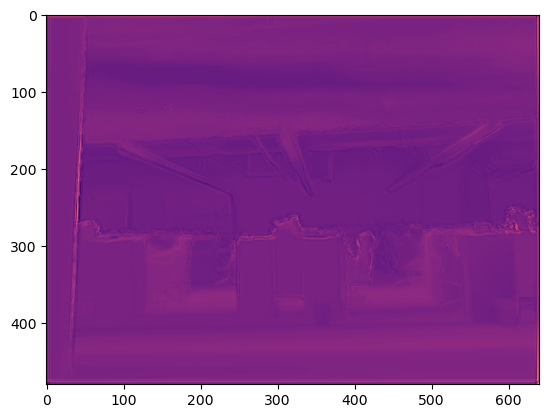

In [36]:
plt.figure()
plt.imshow(dr[0,0,:,:], cmap='magma')
plt.show()

In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import ast
import re


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [20]:
class Middlebury2014(Dataset):
    def __init__(self, data_list_path):
        with open(data_list_path, "r") as f:
            self.data_list = [line.rstrip() for line in f.readlines()]
        self.l_name = "im0.png"
        self.r_name = "im1.png"
        self.l_disp_name = "disp0.pfm"
        self.r_disp_name = "disp1.pfm"
        self.calib_name = "calib.txt"

        self.int_re = re.compile(r"^-?\d+$")
        self.float_re = re.compile(r"^-?\d+\.\d+$")

        transform_list = [
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            transforms.RandAugment(),
        ]
        self.transform = transforms.Compose(transform_list)

    def parse_cam_matrix(self, matrix_str):
        # Remove enclosing brackets
        matrix_str = matrix_str.strip("[]")
        # Split rows on ';'
        rows = matrix_str.split(";")
        # Split each row into individual numbers and convert to float
        matrix = []
        for row in rows:
            row_vals = [float(x) for x in row.strip().split() if x]
            matrix.append(row_vals)
        return np.array(matrix, dtype=np.float32)

    def parse_calib(self, calib_path):
        with open(calib_path, "r") as f:
            data_str = [line.rstrip() for line in f.readlines()]
        data_list = ast.literal_eval(data_str)
        calib_dict = {}
        for item in data_list:
            key, val = item.split("=", maxsplit=1)
            if key.startswith("cam"):
                calib_dict[key] = self.parse_cam_matrix(val)
            else:
                if self.int_re.match(val):
                    parsed_val = int(val)
                elif self.float_re.match(val):
                    parsed_val = float(val)
                else:
                    parsed_val = val  # Keep as string if it doesn't match int or float

                calib_dict[key] = parsed_val
        return calib_dict

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        scene_dir = self.data_list[index]
        left_img_path = os.path.join(scene_dir, self.l_name)
        right_img_path = os.path.join(scene_dir, self.r_name)
        l_disp_path = os.path.join(scene_dir, self.l_disp_name)
        r_disp_path = os.path.join(scene_dir, self.r_disp_name)
        calib_path = os.path.join(scene_dir, self.calib_name)

        l_img = cv2.imread(left_img_path, cv2.IMREAD_ANYCOLOR)[:, :, ::-1]
        r_img = cv2.imread(right_img_path, cv2.IMREAD_ANYCOLOR)[:, :, ::-1]
        l_disp = read_pfm(l_disp_path)
        r_disp = read_pfm(r_disp_path)
        calib_data = self.parse_calib(calib_path)

        if self.transform:
            # Convert images to PIL format for compatibility with transforms
            l_img_pil = transforms.ToPILImage()(l_img)
            r_img_pil = transforms.ToPILImage()(r_img)

            # Apply the same transformation to both images
            l_img_transformed = self.transform(l_img_pil)
            r_img_transformed = self.transform(r_img_pil)
        else:
            # If no transform is provided, convert to tensors manually
            l_img_transformed = torch.from_numpy(l_img).permute(2, 0, 1).float() / 255.0
            r_img_transformed = torch.from_numpy(r_img).permute(2, 0, 1).float() / 255.0

        l_disp_tensor = (
            torch.from_numpy(l_disp).unsqueeze(0).float()
        )  # Shape: [1, H, W]
        r_disp_tensor = (
            torch.from_numpy(r_disp).unsqueeze(0).float()
        )  # Shape: [1, H, W]

        sample = {
            "left_image": l_img_transformed,  # Tensor shape: [3, H, W]
            "right_image": r_img_transformed,  # Tensor shape: [3, H, W]
            "left_disp": l_disp_tensor,  # Tensor shape: [1, H, W]
            "right_disp": r_disp_tensor,  # Tensor shape: [1, H, W]
            "calib_data": calib_data, # dict
        }

        return sample

In [12]:
data_list_path = "/home/william/extdisk/data/middlebury/middlebury2014/middlebury2014_dataset.txt"
with open(data_list_path, 'r') as f:
    data_list = [line.strip() for line in f.readlines()]
    

In [13]:
data_list

['/home/william/extdisk/data/middlebury/middlebury2014/Umbrella-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Sword1-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Bicycle1-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Classroom1-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Couch-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Backpack-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Sticks-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Playtable-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Playroom-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Mask-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Storage-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Adirondack-perfect',
 '/home/william/extdisk/data/middlebury/middlebury2014/Shelves-perfect',
 '/home/william/extdisk/data/middlebury/middle

In [14]:
with open('/home/william/extdisk/data/middlebury/middlebury2014/Umbrella-perfect/calib.txt', 'r') as f:
    calib = [line.rstrip() for line in f.readlines()]

In [15]:
calib

['cam0=[5806.559 0 1429.219; 0 5806.559 993.403; 0 0 1]',
 'cam1=[5806.559 0 1543.51; 0 5806.559 993.403; 0 0 1]',
 'doffs=114.291',
 'baseline=174.019',
 'width=2960',
 'height=2016',
 'ndisp=250',
 'isint=0',
 'vmin=38',
 'vmax=222',
 'dyavg=0',
 'dymax=0']

In [16]:
import ast

data_str = "['cam0=[5806.559 0 1429.219; 0 5806.559 993.403; 0 0 1]', 'cam1=[5806.559 0 1543.51; 0 5806.559 993.403; 0 0 1]', 'doffs=114.291', 'baseline=174.019', 'width=2960', 'height=2016', 'ndisp=250', 'isint=0', 'vmin=38', 'vmax=222', 'dyavg=0', 'dymax=0']"

# Safely parse the string into a Python list
data_list = ast.literal_eval(data_str)

result = {}

for item in data_list:
    # Each item looks like "key=value"
    key, val = item.split('=', maxsplit=1)
    
    # If it's one of the camera matrices, keep it as a string for now
    if key.startswith("cam"):
        # e.g. "cam0=[5806.559 0 1429.219; 0 5806.559 993.403; 0 0 1]"
        # We'll just store the bracketed content as-is
        # If you want to parse it into a numeric matrix, see the next example.
        result[key] = val  
    else:
        # Otherwise, try to convert to int or float if possible
        try:
            # First try integer
            parsed_val = int(val)
        except ValueError:
            # If that fails, try float
            try:
                parsed_val = float(val)
            except ValueError:
                # Otherwise, just keep as string
                parsed_val = val
        
        result[key] = parsed_val

print(result)

{'cam0': '[5806.559 0 1429.219; 0 5806.559 993.403; 0 0 1]', 'cam1': '[5806.559 0 1543.51; 0 5806.559 993.403; 0 0 1]', 'doffs': 114.291, 'baseline': 174.019, 'width': 2960, 'height': 2016, 'ndisp': 250, 'isint': 0, 'vmin': 38, 'vmax': 222, 'dyavg': 0, 'dymax': 0}


In [21]:
m2014 = Middlebury2014(data_list_path="/home/william/extdisk/data/middlebury/middlebury2014/middlebury2014_dataset.txt")
m2014_dataloader = DataLoader(dataset=m2014, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)